# Predicting Mackey-Glass timeseries

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/reservoir_computing/predicting_Mackey_Glass_timeseries.ipynb)

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bp_data

# bm.set_platform('cpu')
bm.set(mode=bm.batching_mode, x64=True)

In [2]:
bp.__version__

'2.4.3'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [4]:
def plot_mackey_glass_series(ts, x_series, x_tau_series, num_sample):
  plt.figure(figsize=(13, 5))

  plt.subplot(121)
  plt.title(f"Timeserie - {num_sample} timesteps")
  plt.plot(ts[:num_sample], x_series[:num_sample], lw=2, color="lightgrey", zorder=0)
  plt.scatter(ts[:num_sample], x_series[:num_sample], c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$t$")
  plt.ylabel("$P(t)$")

  ax = plt.subplot(122)
  ax.margins(0.05)
  plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
  plt.plot(x_tau_series[: num_sample], x_series[: num_sample], lw=1, color="lightgrey", zorder=0)
  plt.scatter(x_tau_series[:num_sample], x_series[: num_sample], lw=0.5, c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$P(t-\\tau)$")
  plt.ylabel("$P(t)$")
  cbar = plt.colorbar()
  # cbar.ax.set_ylabel('$t$', rotation=270)
  cbar.ax.set_ylabel('$t$')

  plt.tight_layout()
  plt.show()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


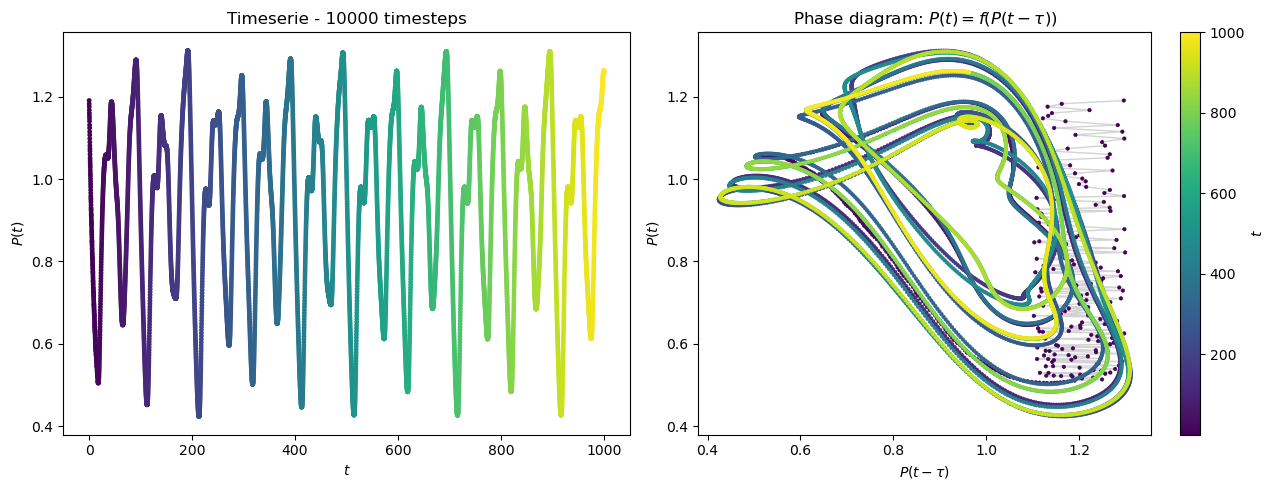

In [5]:
dt = 0.1

mg_data = bp_data.chaos.MackeyGlassEq(25000, dt=dt, tau=17, beta=0.2, gamma=0.1, n=10, inits=1.2, seed=123)

plot_mackey_glass_series(mg_data.ts, mg_data.xs, mg_data.ys, num_sample=int(1000 / dt))

In [6]:
forecast = int(10 / dt)  # predict 10 s ahead
train_length = int(20000 / dt)
sample_rate = int(1 / dt)

X_train = mg_data.xs[:train_length:sample_rate]
Y_train = mg_data.xs[forecast: train_length + forecast: sample_rate]
X_test = mg_data.xs[train_length: -forecast: sample_rate]
Y_test = mg_data.xs[train_length + forecast::sample_rate]

X_train = np.expand_dims(X_train, 0)
Y_train = np.expand_dims(Y_train, 0)
X_test = np.expand_dims(X_test, 0)
Y_test = np.expand_dims(Y_test, 0)

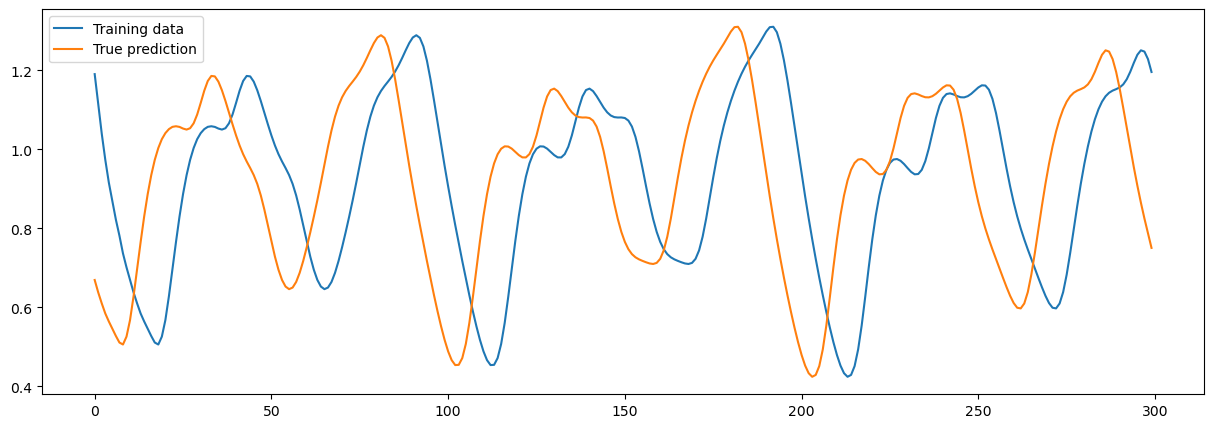

In [7]:
sample = 300
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train.flatten()[:sample], label="Training data")
plt.plot(Y_train.flatten()[:sample], label="True prediction")
plt.legend()
plt.show()

## Model

In [8]:
class ESN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden, num_out):
    super(ESN, self).__init__()
    self.r = bp.dyn.Reservoir(num_in, num_hidden, Wrec_initializer=bp.init.KaimingNormal())
    self.o = bp.dnn.Dense(num_hidden, num_out, mode=bm.training_mode)

  def update(self, x):
    return self.o(self.r(x))


model = ESN(1, 100, 1)

In [9]:
runner = bp.DSTrainer(model)
out = runner.predict(bm.asarray(X_train))

out.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

(1, 20000, 1)

## Training

In [10]:
trainer = bp.RidgeTrainer(model, alpha=1e-6)

In [11]:
_ = trainer.fit([bm.asarray(X_train),
                 bm.asarray(Y_train)])

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Prediction

  0%|          | 0/20000 [00:00<?, ?it/s]

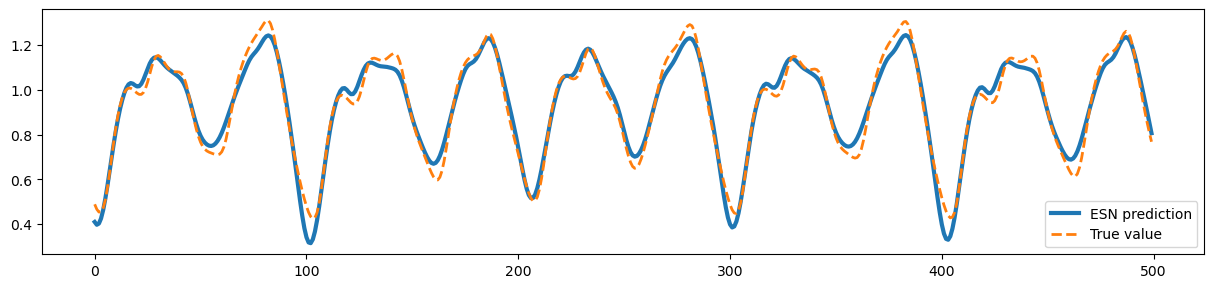

In [12]:
ys_predict = trainer.predict(bm.asarray(X_train), reset_state=True)

start, end = 100, 600
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).to_numpy(),
         bm.as_numpy(ys_predict)[0, start:end, 0],
         lw=3,
         label="ESN prediction")
plt.plot(bm.arange(end - start).to_numpy(),
         Y_train[0, start:end, 0],
         linestyle="--",
         lw=2,
         label="True value")
plt.legend()
plt.show()

  0%|          | 0/4990 [00:00<?, ?it/s]

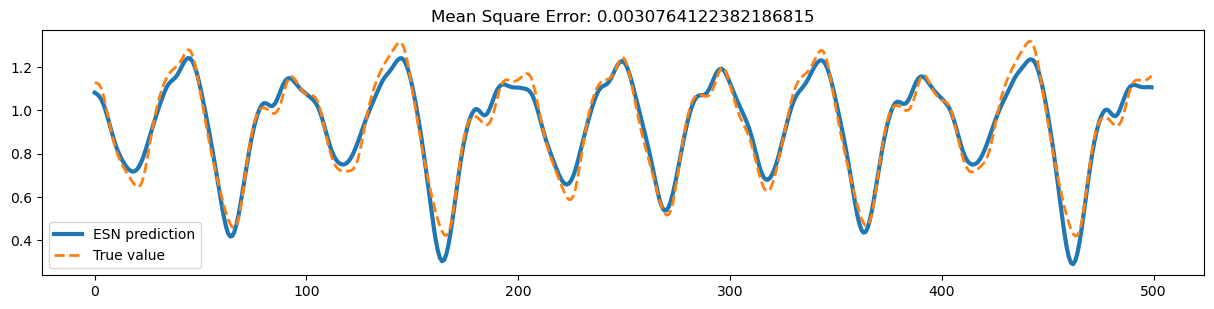

In [13]:
ys_predict = trainer.predict(bm.asarray(X_test), reset_state=True)

start, end = 100, 600
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).to_numpy(),
         bm.as_numpy(ys_predict)[0, start:end, 0],
         lw=3,
         label="ESN prediction")
plt.plot(bm.arange(end - start).to_numpy(),
         Y_test[0, start:end, 0],
         linestyle="--",
         lw=2,
         label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(bm.as_numpy(ys_predict), Y_test)}')
plt.legend()
plt.show()